This Notebook is for generating visualizations across different features of our datasets. We analyse by different retail industries and also look at general distributions across features. We also compare different features against each other. 

In [10]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [11]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.printSchema()
print("length:",df.count())

df_pandas = df.toPandas()

+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-------------------+--------------------------------+---------------------------+------------------+---------------------------------+--------------------+--------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|number_of_orders|average_cost_of_order|number_of_postcodes|avg_total_weekly_personal_income|avg_total_weekly_fam_income|    avg_median_age|avg_num_of_consumers_per_postcode|merchant_description|             segment|
+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-

Summary Statistics for average_consumer_fraud_probability:

count    47.000000
mean      8.327276
std      15.814866
min       0.000000
25%       0.057682
50%       0.148607
75%      12.038684
max      94.703400
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



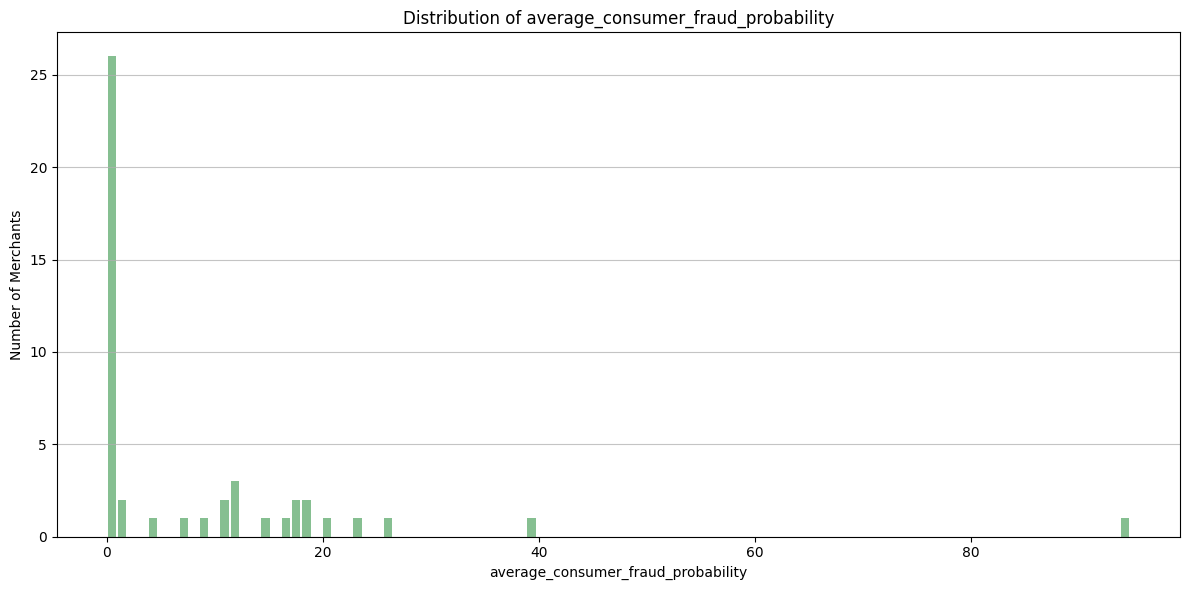

Summary Statistics for avg_median_age:

count    47.000000
mean     42.977001
std       0.866216
min      38.833333
25%      42.963596
50%      43.097323
75%      43.283451
max      44.448276
Name: avg_median_age, dtype: float64

--------------------------------------------------



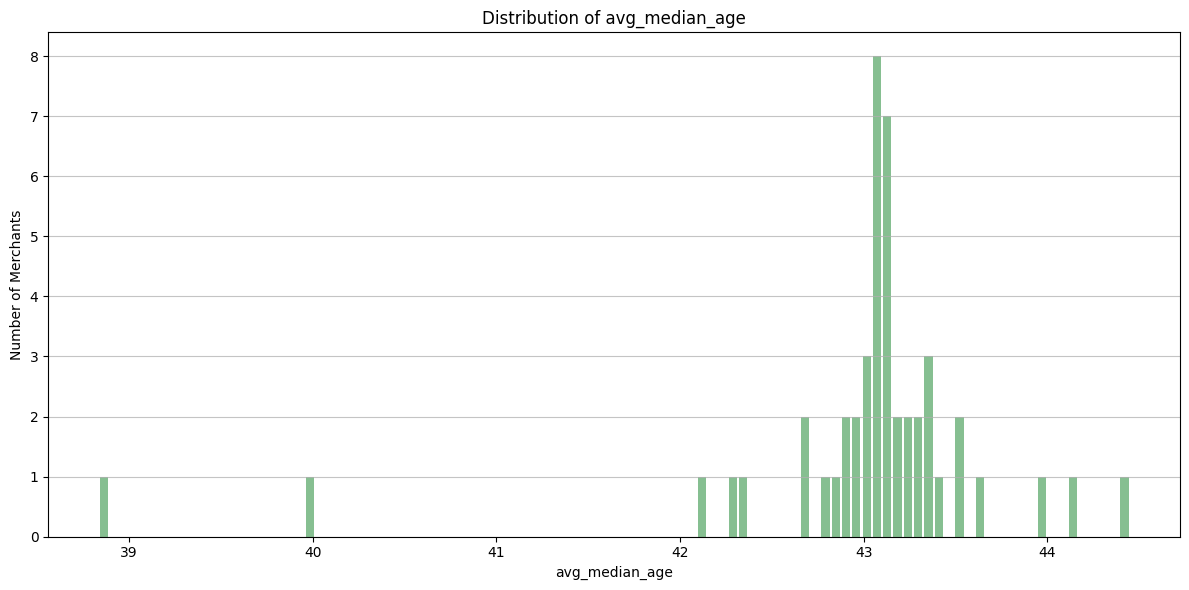

Summary Statistics for avg_total_weekly_personal_income:

count     47.000000
mean     789.684140
std       21.916025
min      735.431034
25%      782.322126
50%      790.375737
75%      792.393614
max      889.000000
Name: avg_total_weekly_personal_income, dtype: float64

--------------------------------------------------



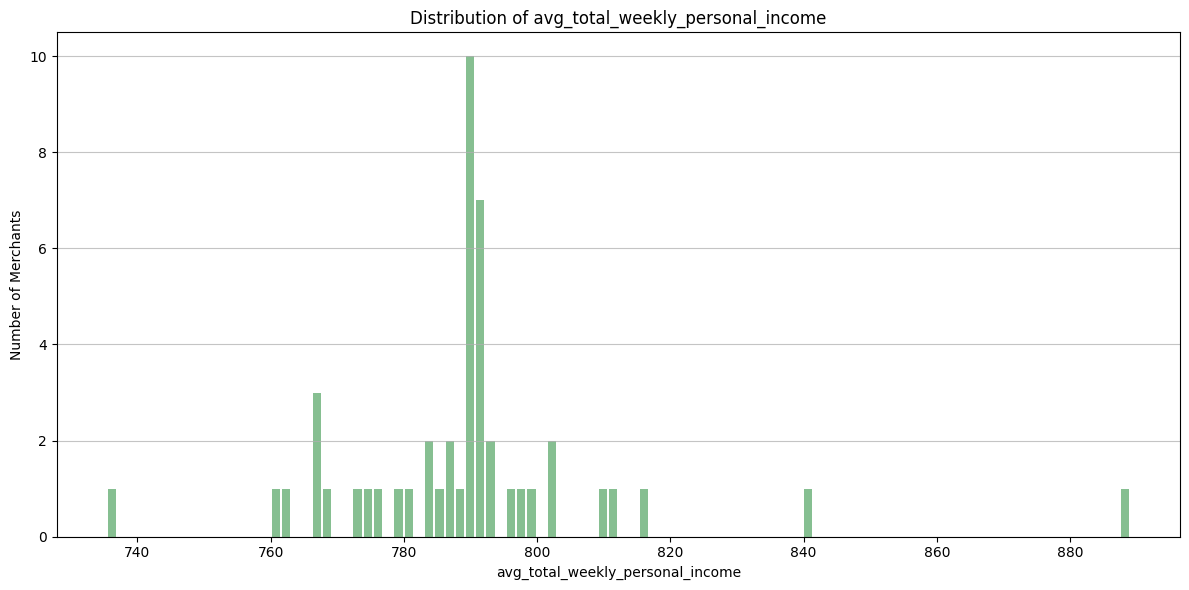

Summary Statistics for take_rate:

count    47.000000
mean      4.226808
std       1.689305
min       0.270000
25%       3.275000
50%       4.580000
75%       5.600000
max       6.820000
Name: take_rate, dtype: float64

--------------------------------------------------



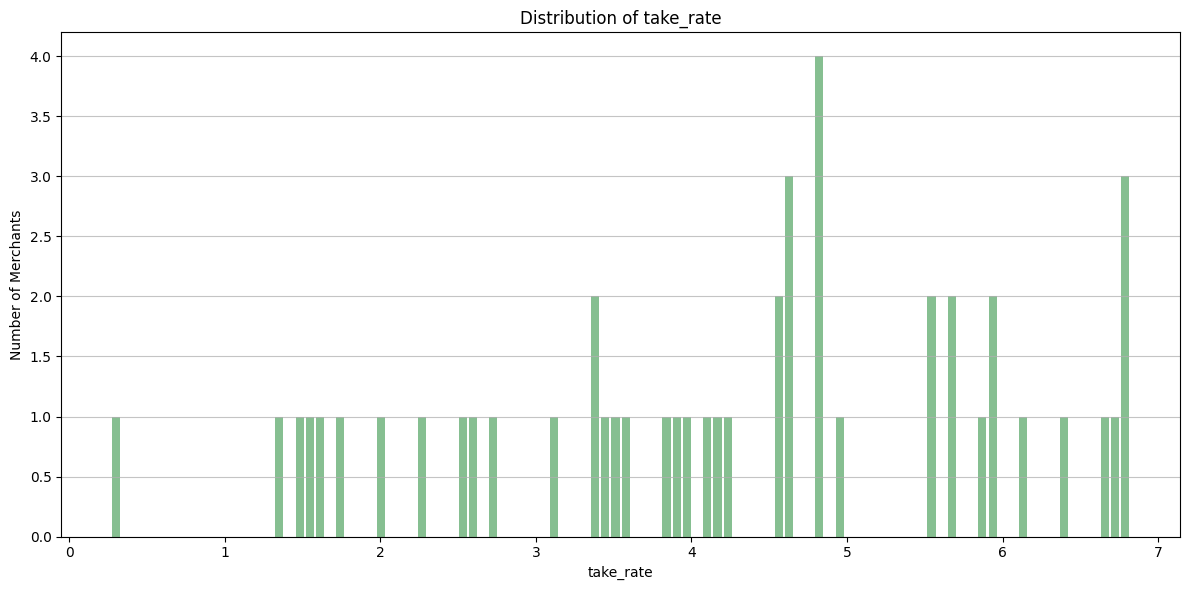

Summary Statistics for average_cost_of_order:

count       47.000000
mean      6452.330575
std       9804.745236
min         20.393330
25%        200.965702
50%        573.788030
75%      11539.577806
max      51876.640000
Name: average_cost_of_order, dtype: float64

--------------------------------------------------



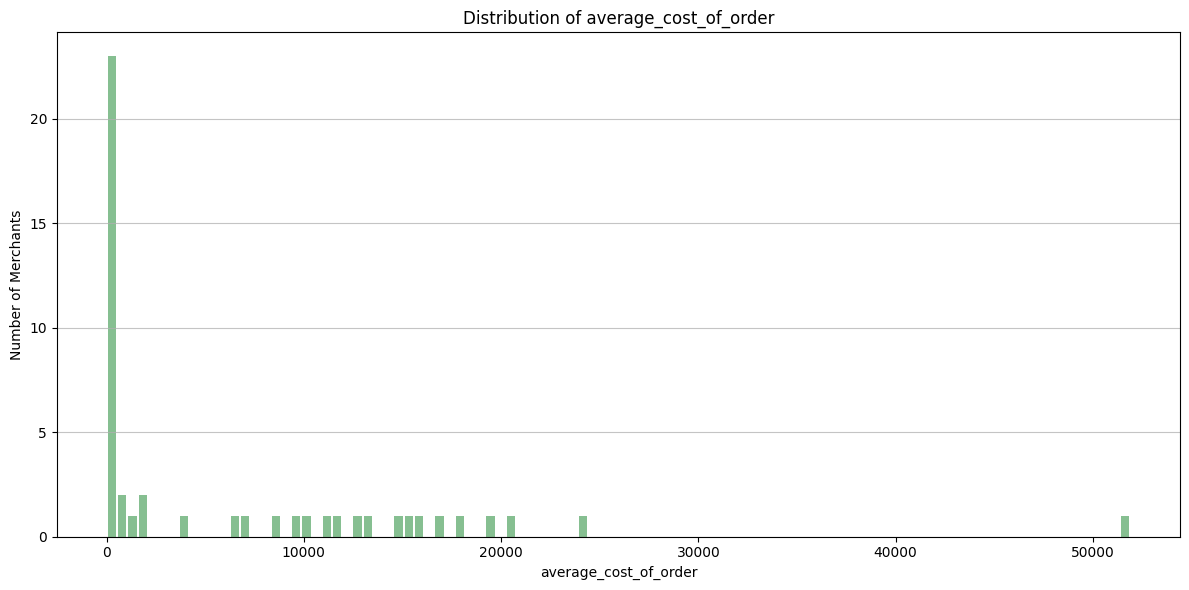

Summary Statistics for number_of_orders:

count        47.000000
mean      10378.276596
std       21259.186579
min           1.000000
25%         111.000000
50%         474.000000
75%       11288.500000
max      100763.000000
Name: number_of_orders, dtype: float64

--------------------------------------------------



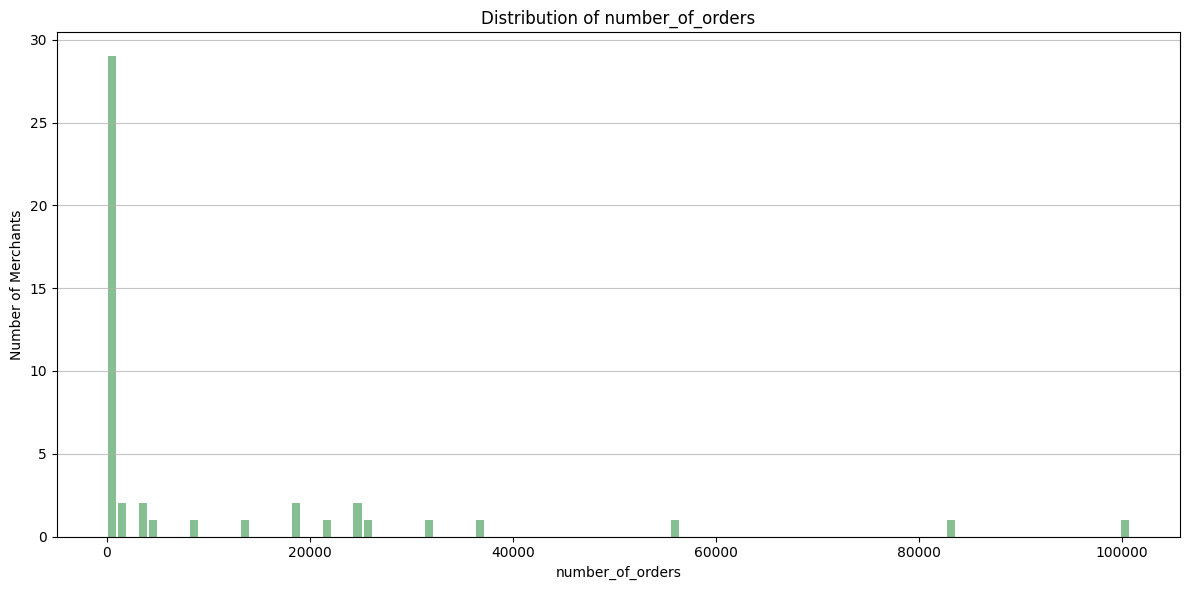

Summary Statistics for number_of_consumers:

count       47.000000
mean      4493.489362
std       6636.249605
min          1.000000
25%        110.500000
50%        470.000000
75%       8588.500000
max      19979.000000
Name: number_of_consumers, dtype: float64

--------------------------------------------------



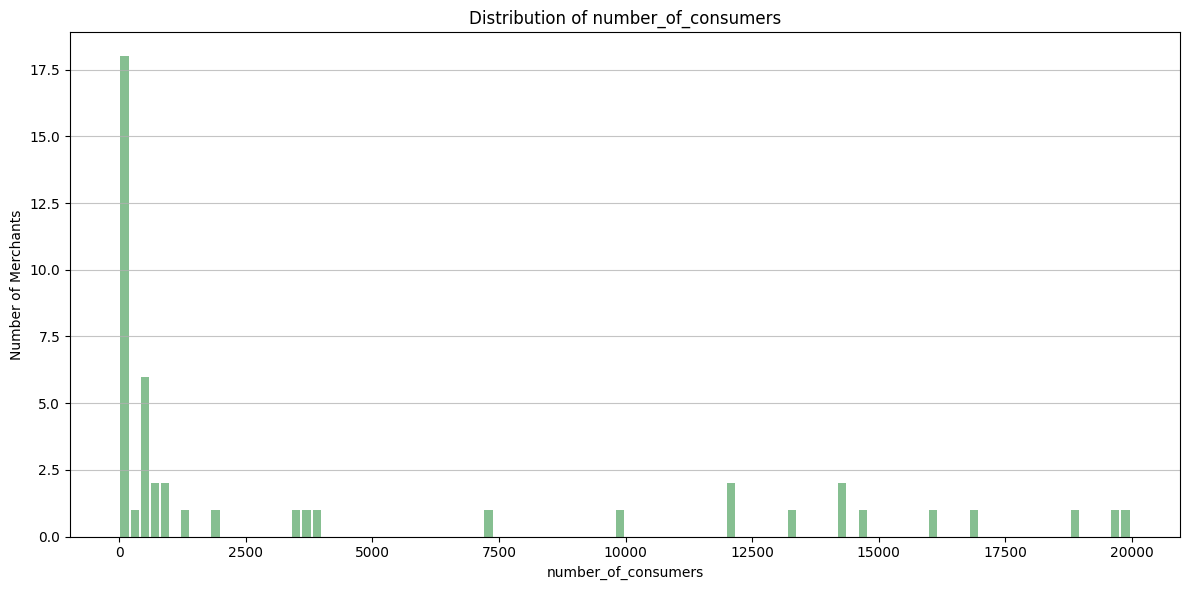

Summary Statistics for average_merchant_fraud_probability:

count    47.000000
mean      1.313311
std       2.898382
min       0.125353
25%       0.259682
50%       0.724312
75%       1.153219
max      18.210900
Name: average_merchant_fraud_probability, dtype: float64

--------------------------------------------------



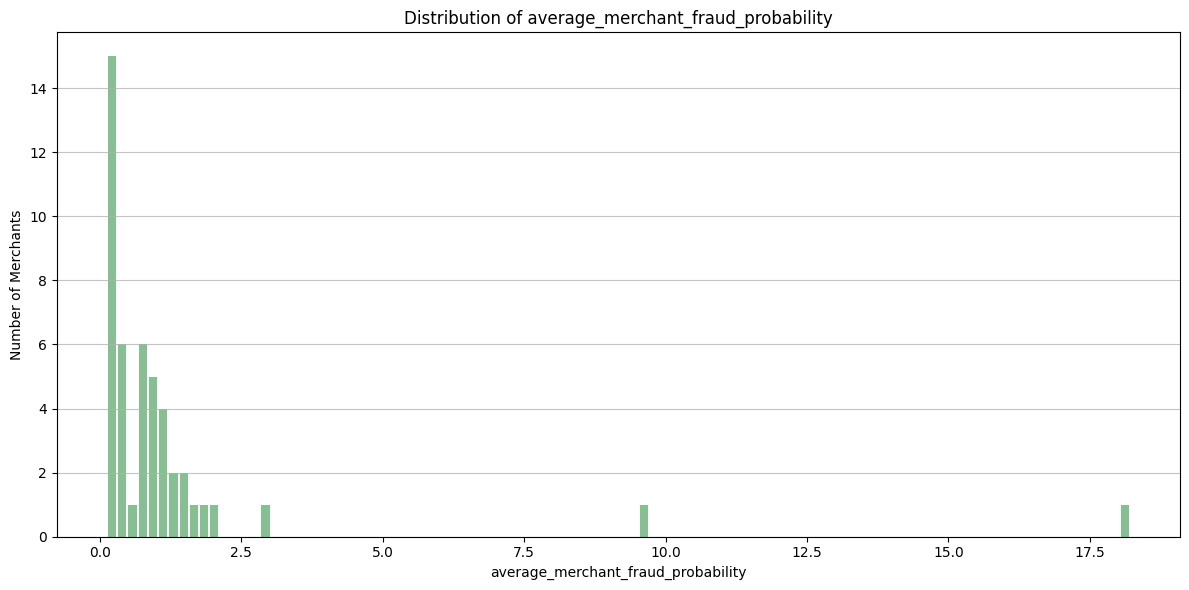

In [20]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "avg_median_age", 
    "avg_total_weekly_personal_income", 
    "take_rate", 
    "average_cost_of_order", 
    "number_of_orders", 
    "number_of_consumers",
    "average_merchant_fraud_probability"
]

# For each column, calculate summary statistics and plot the distribution
for column in columns_to_analyze:
    # Calculate Summary Statistics
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


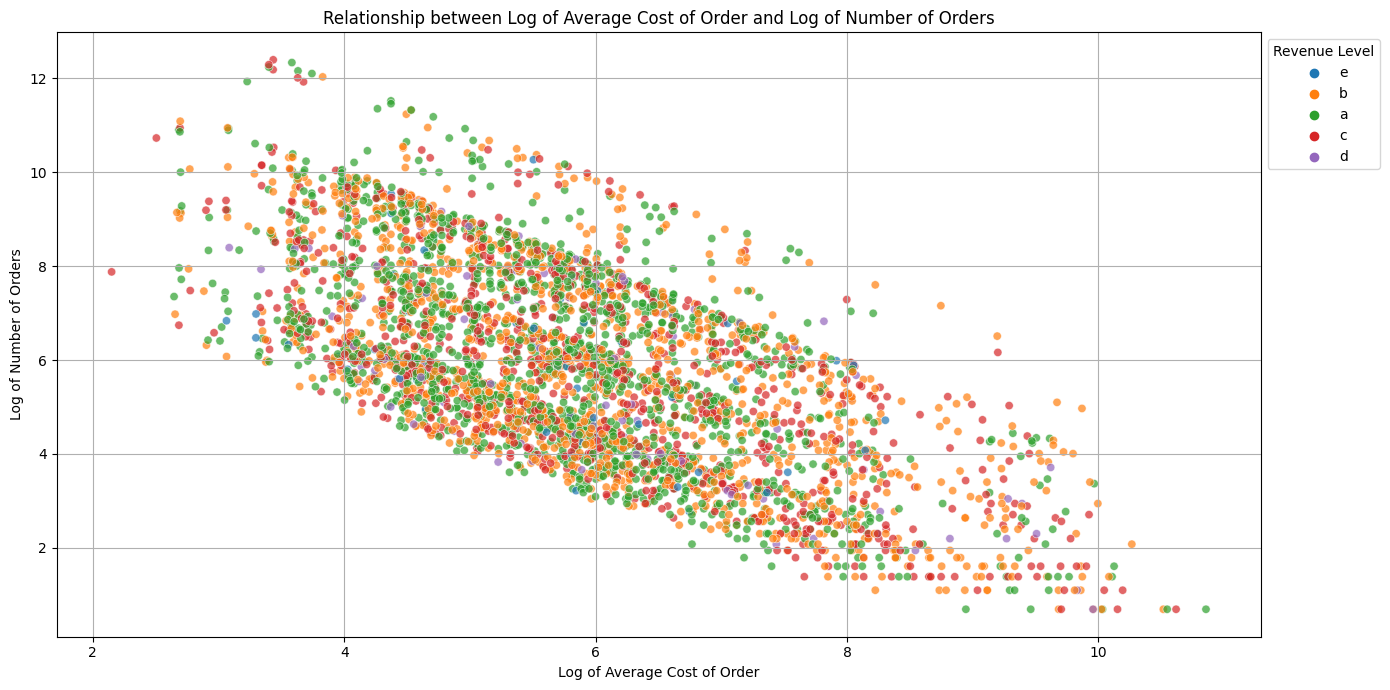

In [13]:
import seaborn as sns
from pyspark.sql.functions import log1p

df = df.withColumn('log_average_cost_of_order', log1p(df['average_cost_of_order']))
df = df.withColumn('log_number_of_orders', log1p(df['number_of_orders']))

# Convert the PySpark dataframe to a pandas dataframe for visualization
df_pandas = df.toPandas()

# Create the scatter plot with revenue_level as hue
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_pandas, x='log_average_cost_of_order', y='log_number_of_orders', hue='revenue_level', palette='tab10', alpha=0.7)
plt.title('Relationship between Log of Average Cost of Order and Log of Number of Orders')
plt.xlabel('Log of Average Cost of Order')
plt.ylabel('Log of Number of Orders')
plt.grid(True)
plt.legend(title='Revenue Level', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [14]:
from pyspark.sql import functions as F

# Assuming df is your DataFrame
filtered_df = df.filter(
    (F.col("average_merchant_fraud_probability") > 0) 
   # (F.col("average_consumer_fraud_probability") > 0)
)


Summary Statistics for average_consumer_fraud_probability:

count    3135.000000
mean        1.314906
std         4.332110
min         0.004561
25%         0.045017
50%         0.075769
75%         0.493818
max        94.703400
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



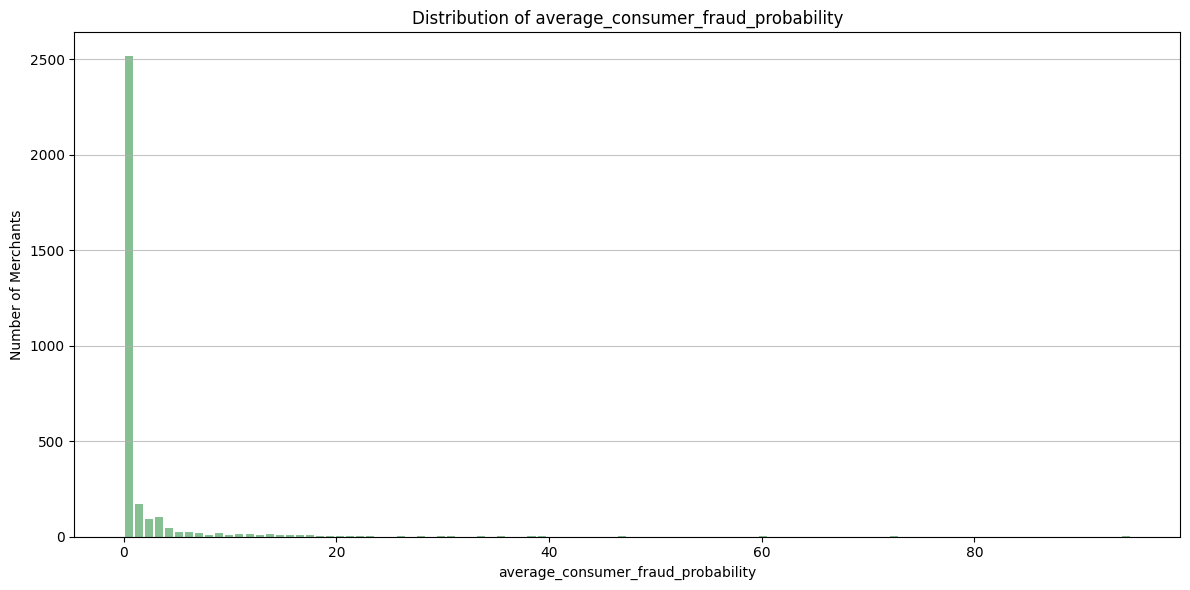

Summary Statistics for average_merchant_fraud_probability:

count    47.000000
mean      1.313311
std       2.898382
min       0.125353
25%       0.259682
50%       0.724312
75%       1.153219
max      18.210900
Name: average_merchant_fraud_probability, dtype: float64

--------------------------------------------------



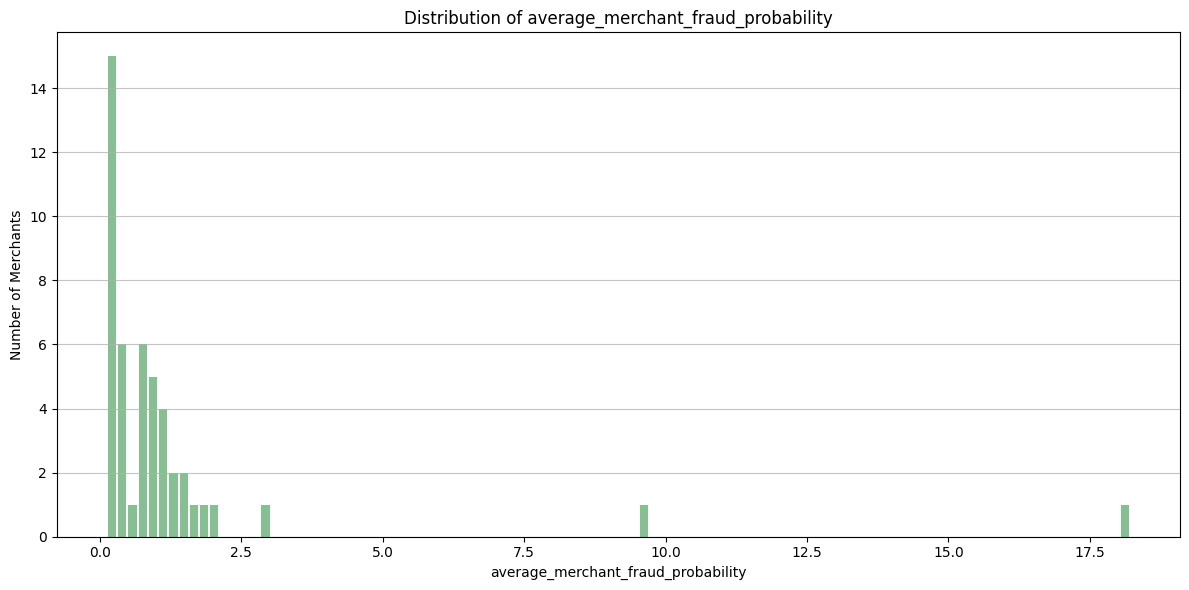

In [15]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "average_merchant_fraud_probability"
]
df_pandas = filtered_df.toPandas()
# For each column, calculate summary statistics and plot the distribution
for column in columns_to_analyze:
    filtered_df = df.filter(
    (F.col(column) > 0) 
)   
    df_pandas = filtered_df.toPandas()
    # Calculate Summary Statistics
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


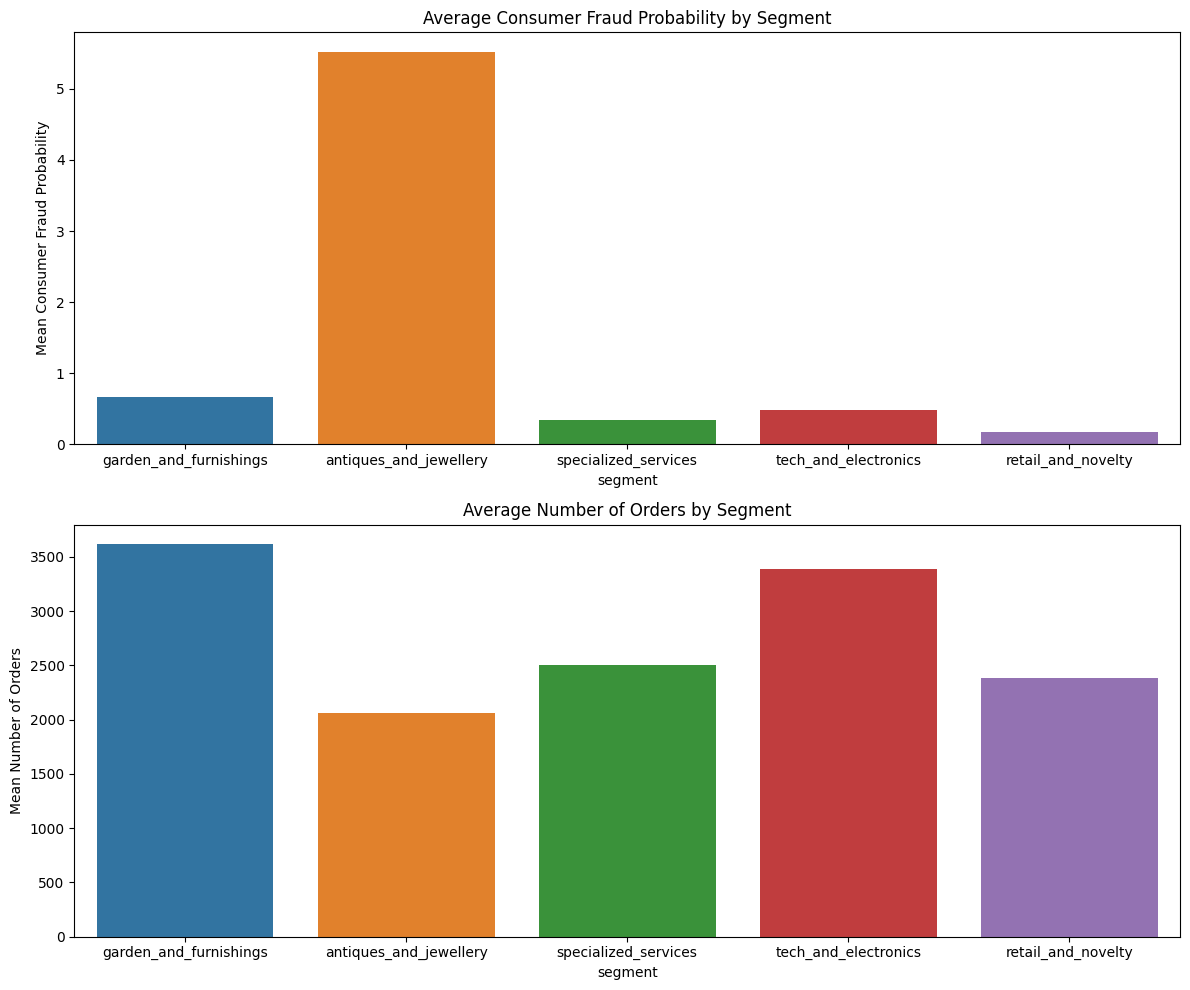

In [16]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Group by segment and aggregate the mean and standard deviation
agg_data = df.groupBy("segment").agg(
    F.mean("average_consumer_fraud_probability").alias("mean_consumer_fraud"),
    F.stddev("average_consumer_fraud_probability").alias("stddev_consumer_fraud"),
    F.mean("number_of_orders").alias("mean_orders"),
    F.stddev("number_of_orders").alias("stddev_orders")
)

# Convert the aggregated data to Pandas DataFrame for visualization
agg_data_pandas = agg_data.toPandas()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Average consumer fraud probability by segment
sns.barplot(x="segment", y="mean_consumer_fraud", data=agg_data_pandas, ax=axes[0])
axes[0].set_title('Average Consumer Fraud Probability by Segment')
axes[0].set_ylabel('Mean Consumer Fraud Probability')

# Number of orders by segment
sns.barplot(x="segment", y="mean_orders", data=agg_data_pandas, ax=axes[1])
axes[1].set_title('Average Number of Orders by Segment')
axes[1].set_ylabel('Mean Number of Orders')

plt.tight_layout()
plt.show()


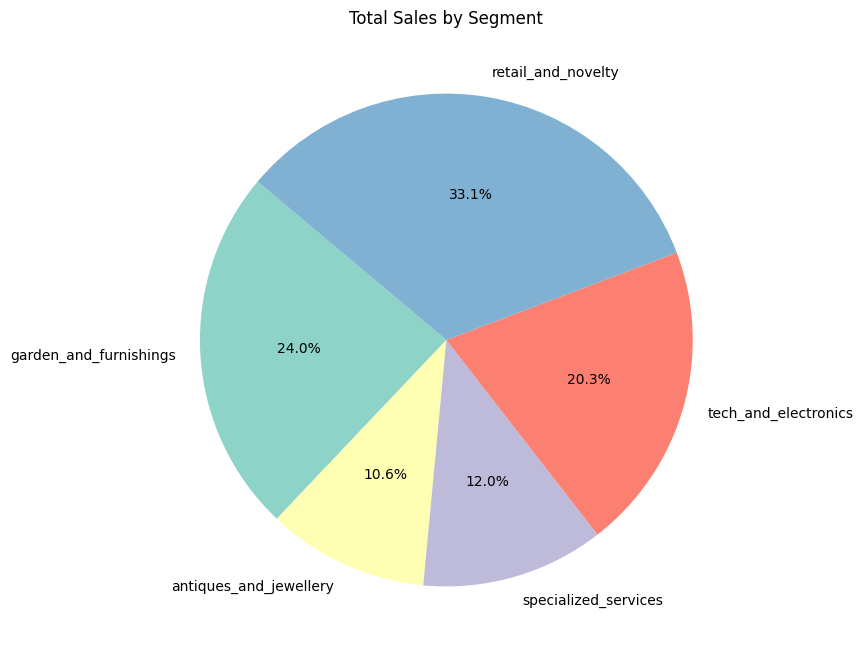

In [17]:
# Group by segment and aggregate total sales for each segment
agg_sales = df.groupBy("segment").agg(
    F.sum(df.number_of_orders * df.average_cost_of_order).alias("total_sales")
)

# Convert the aggregated data to a Pandas DataFrame for visualization
sales_pandas = agg_sales.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(sales_pandas["total_sales"], labels=sales_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(sales_pandas)))
plt.title('Total Sales by Segment')
plt.show()


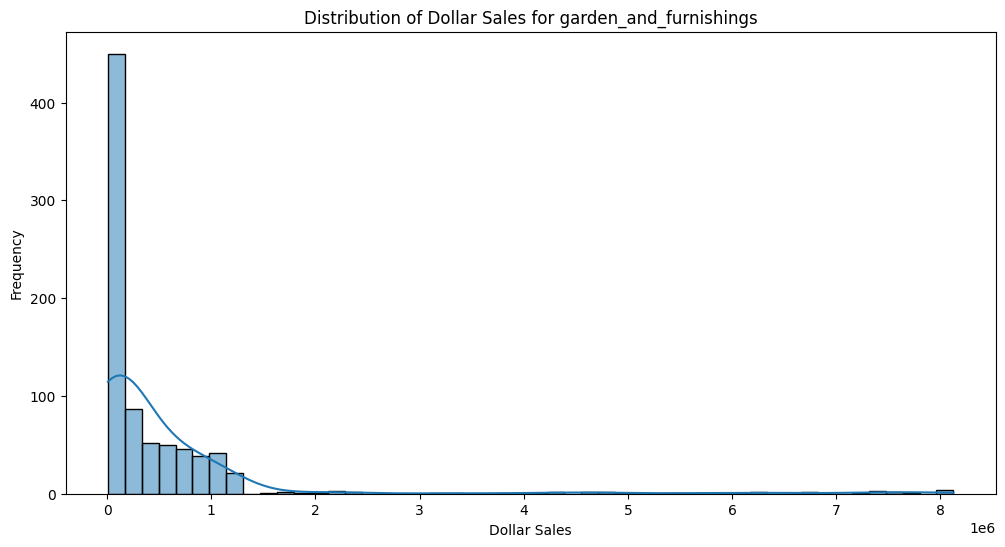

,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,number_of_orders,average_cost_of_order,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_num_of_consumers_per_postcode,merchant_description,segment,log_average_cost_of_order,log_number_of_orders,dollar_sales
0,13467303030,Duis LLP,a,5.51,0.000000,6,2.333733,NaN,6,1590.230000,6,794.583333,2203.666667,39.166667,1.000000,tent and awning shops,garden_and_furnishings,7.372263,1.945910,9541.38
1,17028880379,Sem Mollis Inc.,a,6.26,0.000000,42,0.000000,NaN,42,219.238095,42,781.892857,1922.321429,45.154762,1.000000,"lawn and garden supply outlets, including nurs...",garden_and_furnishings,5.394709,3.761200,9208.00
2,29681526553,Cras Vehicula Aliquet Corp.,a,6.24,0.000000,19,0.000000,NaN,19,454.314211,19,771.289474,1914.052632,41.236842,1.000000,tent and awning shops,garden_and_furnishings,6.120988,2.995732,8631.97
3,38090089066,Interdum Feugiat Sed Inc.,b,3.24,0.000000,17778,0.056874,12724.0,43307,171.993569,43307,791.820075,1983.910650,43.108250,16.422829,"furniture, home furnishings and equipment shop...",garden_and_furnishings,5.153254,10.676093,7448525.51
4,38523766800,Elit Elit Fermentum Foundation,a,5.94,0.000000,5,0.000000,NaN,5,1313.750000,5,792.000000,2060.700000,41.100000,1.000000,"furniture, home furnishings and equipment shop...",garden_and_furnishings,7.181402,1.791759,6568.75
5,38700038932,Etiam Bibendum Industries,a,6.31,0.000000,5154,0.605566,707.0,5944,1344.342692,5944,794.789283,1984.221484,43.092110,2.600175,tent and awning shops,garden_and_furnishings,7.204404,8.690306,7990772.96
6,43186523025,Lorem Ipsum Sodales Industries,b,4.47,0.000000,20110,0.042782,20070.0,167890,45.000276,167890,790.156829,1977.144687,43.101486,63.618795,"florists supplies, nursery stock, and flowers",garden_and_furnishings,3.828647,12.031070,7555096.29
7,50315283629,Iaculis Aliquet Diam LLC,c,1.76,0.240904,14301,0.065827,7070.0,24910,322.985718,24910,791.959956,1982.975893,43.134183,9.467883,"lawn and garden supply outlets, including nurs...",garden_and_furnishings,5.780699,10.123065,8045574.24
8,66650274915,Gravida Praesent Industries,a,6.30,0.000000,25,0.000000,NaN,25,358.860800,25,810.880000,2089.680000,43.660000,1.000000,"florists supplies, nursery stock, and flowers",garden_and_furnishings,5.885717,3.258097,8971.52
9,69853421807,Fusce Mollis Duis Industries,a,6.28,0.000000,3,0.000000,NaN,3,2892.423333,3,703.666667,1713.333333,48.333333,1.000000,"equipment, tool, furniture, and appliance rent...",garden_and_furnishings,7.970196,1.386294,8677.27


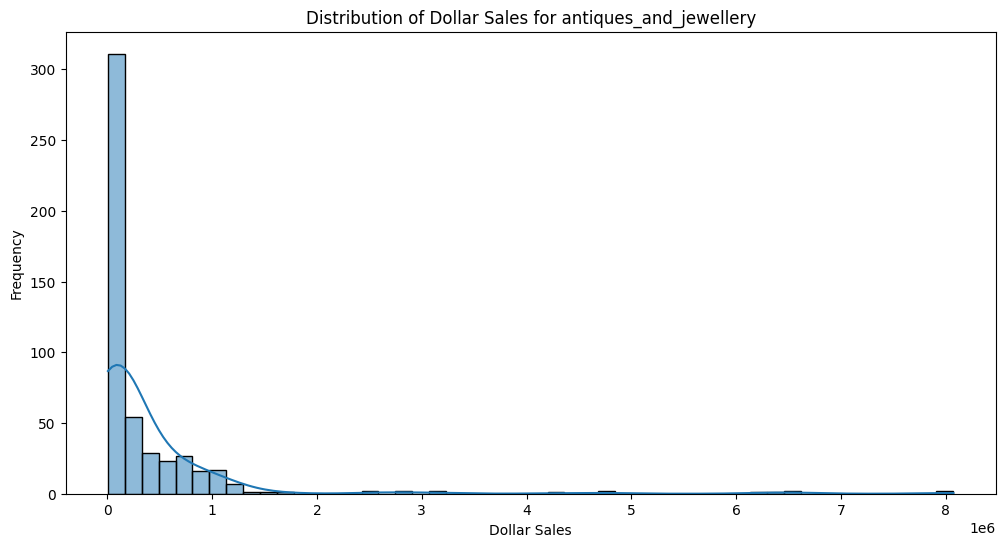

,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,number_of_orders,average_cost_of_order,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_num_of_consumers_per_postcode,merchant_description,segment,log_average_cost_of_order,log_number_of_orders,dollar_sales
0,18714755910,Feugiat Non Lobortis Ltd,a,5.61,0.000000,95,0.000000,NaN,95,87.462947,95,829.205263,1982.121053,43.142105,1.032609,"watch, clock, and jewelry repair shops",antiques_and_jewellery,4.482584,4.564348,8308.98
1,19492220327,Commodo Ipsum Industries,b,4.93,1.298691,661,11.418629,10.0,671,9853.593249,671,784.783159,1968.808495,42.918033,1.131535,"jewelry, watch, clock, and silverware shops",antiques_and_jewellery,9.195693,6.510258,6611761.07
2,22019281430,Ipsum Suspendisse Corporation,b,4.42,0.000000,3,8.995167,NaN,3,2562.133333,3,653.666667,1608.833333,41.666667,1.000000,art dealers and galleries,antiques_and_jewellery,7.848986,1.386294,7686.40
3,31334588839,Lacus Aliquam Corporation,b,4.22,1.529354,1239,7.372896,44.0,1283,6292.100701,1283,781.452455,1958.130164,43.203429,1.294652,"antique shops - sales, repairs, and restoratio...",antiques_and_jewellery,8.747209,7.157735,8072765.20
4,49322182190,Gravida Mauris Incorporated,a,6.35,0.000000,17857,0.048793,12894.0,43435,151.312792,43435,789.779970,1977.217106,43.121031,16.465125,"watch, clock, and jewelry repair shops",antiques_and_jewellery,5.025936,10.679044,6572271.10
5,51425051982,Sem Corporation,a,5.71,0.000000,1,0.000000,NaN,1,7677.630000,1,471.000000,1176.000000,55.000000,1.000000,"antique shops - sales, repairs, and restoratio...",antiques_and_jewellery,8.946196,0.693147,7677.63
6,64648788229,Nisl Maecenas LLC,c,2.10,0.000000,3,0.000000,NaN,3,2122.066667,3,726.000000,1843.666667,42.666667,1.000000,"jewelry, watch, clock, and silverware shops",antiques_and_jewellery,7.660617,1.386294,6366.20
7,68559320474,Aliquam Auctor Associates,b,4.20,0.000000,15501,0.047552,8786.0,29691,215.835339,29691,788.716328,1971.207420,43.099121,11.285063,"antique shops - sales, repairs, and restoratio...",antiques_and_jewellery,5.379138,10.298633,6408367.04
8,86578477987,Leo In Consulting,a,6.43,0.000000,20115,0.043976,20113.0,227812,34.998829,227812,790.122033,1978.244362,43.121872,86.325123,"watch, clock, and jewelry repair shops",antiques_and_jewellery,3.583486,12.336280,7973153.13
9,99785979138,Elit Curabitur LLP,a,6.82,0.000000,7,0.000000,NaN,7,867.808571,7,760.142857,1821.500000,45.000000,1.000000,art dealers and galleries,antiques_and_jewellery,6.767123,2.079442,6074.66


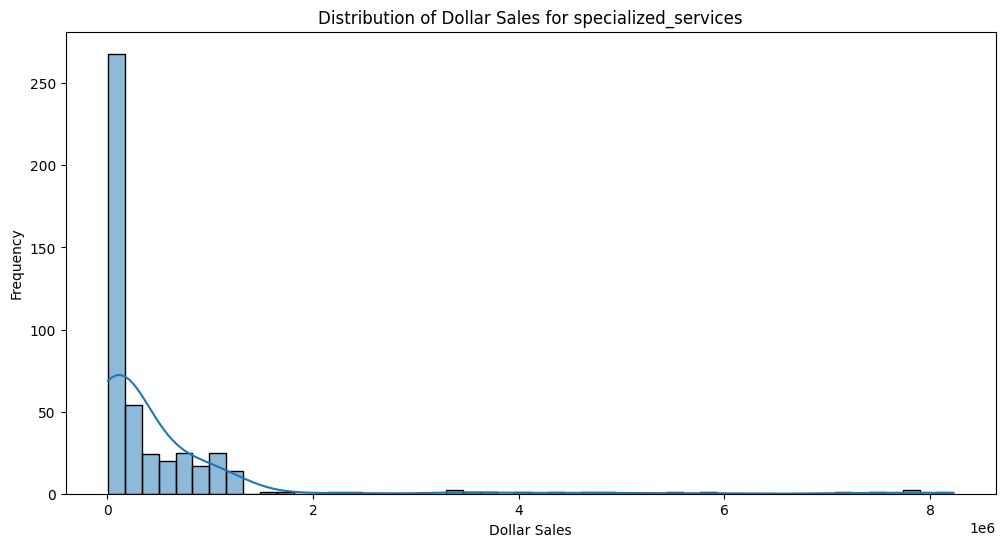

,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,number_of_orders,average_cost_of_order,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_num_of_consumers_per_postcode,merchant_description,segment,log_average_cost_of_order,log_number_of_orders,dollar_sales
0,18158387243,Nec Tellus Ltd,c,2.03,0.264597,9903,0.087590,2984.0,13606,573.788030,13606,790.816588,1975.538402,42.989049,5.257342,health and beauty spas,specialized_services,6.354001,9.518340,7806959.94
1,22033359776,Suspendisse Non Leo PC,b,3.10,0.000000,12617,0.058950,5134.0,19671,377.484755,19671,789.248538,1975.901708,43.132022,7.505151,motor vehicle supplies and new parts,specialized_services,5.936176,9.886952,7425502.61
2,25963848680,Vitae Foundation,a,6.86,0.000000,57,0.000000,NaN,57,132.877018,57,807.859649,2057.368421,44.473684,1.000000,"opticians, optical goods, and eyeglasses",specialized_services,4.896922,4.060443,7573.99
3,31570712230,Pharetra Nam Corporation,a,6.44,0.000000,58,0.000000,NaN,58,140.907759,58,768.568966,1938.129310,43.508621,1.000000,health and beauty spas,specialized_services,4.955177,4.077537,8172.65
4,48534649627,Dignissim Maecenas Foundation,a,6.64,0.339672,18885,0.044932,15416.0,55672,141.827222,55672,790.075316,1978.717569,43.091985,21.095870,"opticians, optical goods, and eyeglasses",specialized_services,4.961636,10.927251,7895805.09
5,58812213085,Fusce Aliquet Incorporated,c,2.20,0.000000,119,0.000000,NaN,119,73.562773,119,785.336134,1966.058824,42.760504,1.017094,"opticians, optical goods, and eyeglasses",specialized_services,4.311641,4.787492,8753.97
6,59477140425,Amet Orci Ut LLP,b,3.92,0.000000,17,0.000000,NaN,17,525.526471,17,726.558824,1818.764706,46.735294,1.000000,health and beauty spas,specialized_services,6.266302,2.890372,8933.95
7,96680767841,Ornare Limited,a,5.91,0.148076,14645,0.052490,7476.0,26147,314.630534,26147,791.735285,1980.330229,43.107641,9.949391,motor vehicle supplies and new parts,specialized_services,5.754572,10.171528,8226644.57


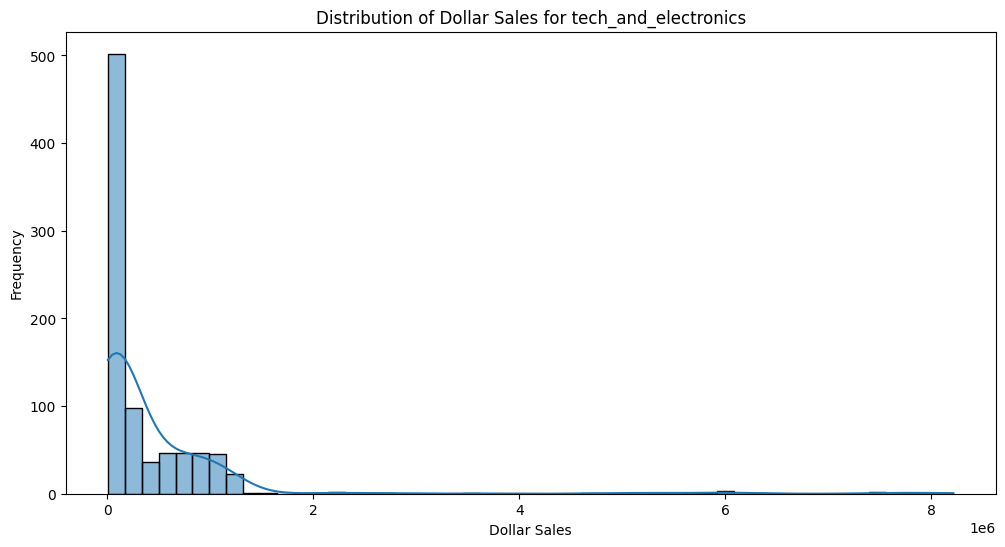

,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,number_of_orders,average_cost_of_order,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_num_of_consumers_per_postcode,merchant_description,segment,log_average_cost_of_order,log_number_of_orders,dollar_sales
0,15514494276,Et Euismod Et Associates,a,5.96,0.000000,25,0.000000,NaN,25,335.322800,25,713.600000,1764.480000,45.620000,1.000000,"computers, computer peripheral equipment, and ...",tech_and_electronics,5.818071,3.258097,8383.07
1,18112900644,Lacus Etiam Institute,b,4.19,0.000000,226,0.039305,3.0,229,37.297773,229,801.216157,1967.768559,42.989083,1.040909,"computers, computer peripheral equipment, and ...",tech_and_electronics,3.645392,5.438079,8541.19
2,21439773999,Mauris Non Institute,a,6.10,0.127016,19979,0.044972,19324.0,100763,78.176124,100763,791.310804,1980.926029,43.088142,38.196740,"cable, satellite, and other pay television and...",tech_and_electronics,4.371675,11.520536,7877260.78
3,31468420954,Non Hendrerit Id LLC,c,2.49,0.000000,57,0.000000,NaN,57,157.130526,57,828.657895,2052.236842,42.701754,1.000000,"computer programming , data processing, and in...",tech_and_electronics,5.063421,4.060443,8956.44
4,34096466752,Nullam Enim Ltd,b,3.22,0.000000,10697,0.056885,3646.0,15435,498.846327,15435,794.391804,1987.360544,42.998056,5.947977,"computers, computer peripheral equipment, and ...",tech_and_electronics,6.214301,9.644458,7699693.05
5,35909341340,Arcu Sed Eu Incorporated,b,4.80,0.131210,16010,0.040672,9455.0,31973,251.118922,31973,789.544866,1978.781519,43.140259,12.133966,"computer programming , data processing, and in...",tech_and_electronics,5.529901,10.372678,8029025.30
6,49505931725,Suspendisse Ac Associates,b,4.70,0.000000,18949,0.045606,15668.0,57054,105.142514,57054,788.573650,1976.129754,43.123926,21.619553,"digital goods: books, movies, music",tech_and_electronics,4.664783,10.951771,5998800.99
7,56766066037,Nam Corp.,b,4.14,0.000000,2,9.438250,NaN,2,3734.290000,2,835.000000,2141.500000,41.000000,1.000000,telecom,tech_and_electronics,8.225581,1.098612,7468.58
8,60061618643,Aliquet Vel Vulputate Ltd,a,6.94,0.000000,78,0.123003,NaN,78,115.008718,78,789.102564,2005.166667,43.987179,1.000000,"computer programming , data processing, and in...",tech_and_electronics,4.753665,4.369448,8970.68
9,73046248717,Donec Fringilla Limited,a,6.26,0.000000,98,0.000000,NaN,98,83.981327,98,793.969388,2002.846939,42.668367,1.000000,"digital goods: books, movies, music",tech_and_electronics,4.442432,4.595120,8230.17


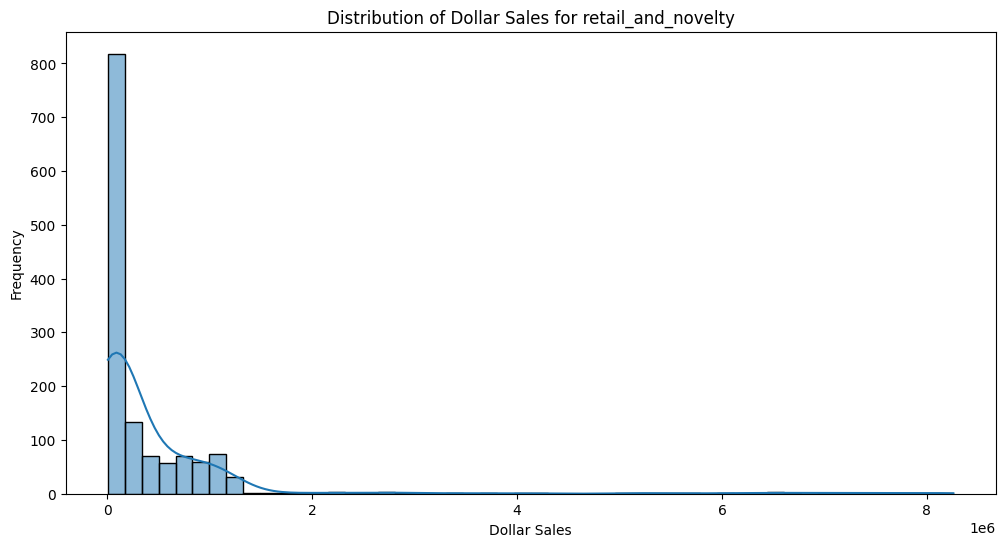

,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,number_of_orders,average_cost_of_order,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_num_of_consumers_per_postcode,merchant_description,segment,log_average_cost_of_order,log_number_of_orders,dollar_sales
0,15704713883,Faucibus Ut Nulla Ltd,c,2.66,0.000000,21,0.000000,NaN,21,441.430476,21,727.309524,1830.214286,45.047619,1.000000,bicycle shops - sales and service,retail_and_novelty,6.092283,3.091042,9270.04
1,17507773571,Libero Nec Limited,a,5.89,0.000000,4,5.014900,NaN,4,1635.700000,4,681.625000,1682.500000,44.500000,1.000000,"hobby, toy and game shops",retail_and_novelty,7.400437,1.609438,6542.80
2,27093785141,Placerat Orci Institute,c,2.73,0.392346,13219,0.062052,5924.0,21576,376.349024,21576,790.539141,1979.166643,43.049198,8.235115,"stationery, office supplies and printing and w...",retail_and_novelty,5.933171,9.979383,8120106.54
3,28057731482,Dignissim Lacus PC,c,1.47,0.000000,8292,0.066448,1892.0,10552,740.925720,10552,788.555392,1975.825104,43.123721,4.149430,"music shops - musical instruments, pianos, and...",retail_and_novelty,6.609249,9.264165,7818248.20
4,30749472383,Pharetra Sed Foundation,a,6.33,0.000000,36,0.000000,NaN,36,202.357778,36,763.888889,1810.625000,44.055556,1.000000,"books, periodicals, and newspapers",retail_and_novelty,5.314967,3.610918,7284.88
5,32361057556,Orci In Consequat Corporation,a,6.61,0.000000,19535,0.045323,17568.0,71733,109.885063,71733,790.882822,1978.125145,43.099313,27.181887,"gift, card, novelty, and souvenir shops",retail_and_novelty,4.708494,11.180720,7882385.25
6,32709545238,Tempor Est Foundation,c,3.04,0.000000,8349,0.137230,1984.0,10702,752.113386,10702,787.893945,1974.447300,43.219912,4.241776,"stationery, office supplies and printing and w...",retail_and_novelty,6.624216,9.278279,8049117.46
7,33754604709,Nullam Suscipit Ltd,b,3.25,0.000000,20,0.000000,NaN,20,389.032000,20,833.425000,2044.025000,44.250000,1.000000,bicycle shops - sales and service,retail_and_novelty,5.966229,3.044522,7780.64
8,39649557865,Arcu Morbi Institute,c,1.47,0.125353,12088,0.072486,4590.0,18310,451.046252,18310,790.953058,1980.631486,43.056144,7.020706,artist supply and craft shops,retail_and_novelty,6.113785,9.815257,8258656.87
9,41944909975,Et Nunc Consulting,e,0.16,0.000000,15245,0.046899,8432.0,28780,245.025832,28780,791.565601,1982.564646,43.051894,10.930498,"books, periodicals, and newspapers",retail_and_novelty,5.505437,10.267471,7051843.44


In [18]:
segments = df.select("segment").distinct().rdd.flatMap(lambda x: x).collect()

for segment in segments:
    segment_df = df.filter(df.segment == segment)
    
    # Check if the segment dataframe is not empty
    if segment_df.count() > 0:
        segment_df = segment_df.withColumn("dollar_sales", col("average_cost_of_order") * col("number_of_orders"))

        # Calculate 1% and 99% percentiles for dollar sales
        lower_bound = segment_df.approxQuantile("dollar_sales", [0.01], 0.0)[0]
        upper_bound = segment_df.approxQuantile("dollar_sales", [0.99], 0.0)[0]
        plt.figure(figsize=(12, 6))
        segment_df_pandas = segment_df.toPandas()
        sns.histplot(segment_df_pandas['dollar_sales'], kde=True, bins=50)
        plt.title(f'Distribution of Dollar Sales for {segment}')
        plt.xlabel('Dollar Sales')
        plt.ylabel('Frequency')
        plt.show()
        # Filter outliers
        outliers = segment_df.filter((segment_df.dollar_sales < lower_bound) | (segment_df.dollar_sales > upper_bound))
        
        # Display outliers if any
        if outliers.count() > 0:
            display(outliers.toPandas())
    else:
        print(f"No data for segment: {segment}")


/tmp/ipykernel_1997/3220974520.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')


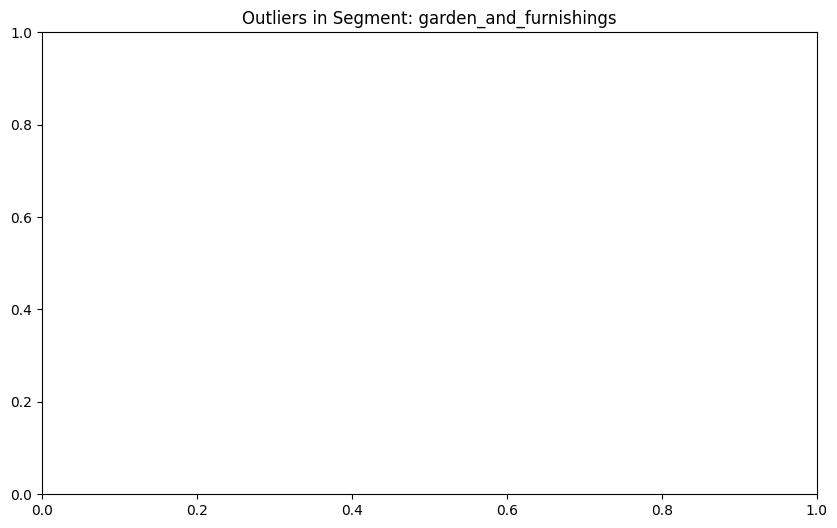

Empty DataFrame
Columns: [merchant_abn, name, revenue_level, take_rate, average_merchant_fraud_probability, number_of_consumers, average_consumer_fraud_probability, number_of_repeat_consumers, number_of_orders, average_cost_of_order, number_of_postcodes, avg_total_weekly_personal_income, avg_total_weekly_fam_income, avg_median_age, avg_num_of_consumers_per_postcode, merchant_description, segment, log_average_cost_of_order, log_number_of_orders]
Index: []


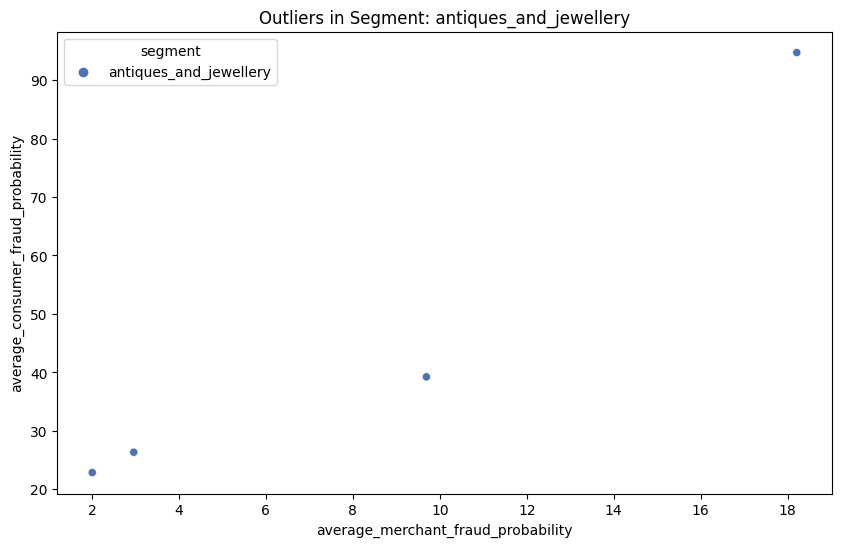

     merchant_abn                               name revenue_level  take_rate  \
11    11149063370                    Et Arcu Limited             b       4.84   
336   67264251405          Elit Dictum Eu Foundation             a       6.40   
414   83199298021     Ligula Elit Pretium Foundation             b       4.82   
445   89109402284  Interdum Feugiat Sed Incorporated             b       3.87   

     average_merchant_fraud_probability  number_of_consumers  \
11                             2.960385                   54   
336                           18.210900                    1   
414                            2.006359                  143   
445                            9.691367                    3   

     average_consumer_fraud_probability  number_of_repeat_consumers  \
11                            26.333317                         NaN   
336                           94.703400                         NaN   
414                           22.849778                     

/tmp/ipykernel_1997/3220974520.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')


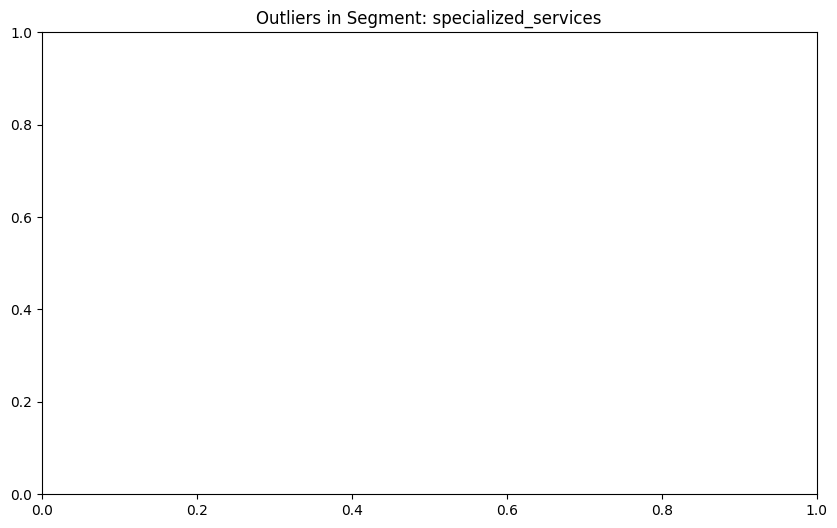

Empty DataFrame
Columns: [merchant_abn, name, revenue_level, take_rate, average_merchant_fraud_probability, number_of_consumers, average_consumer_fraud_probability, number_of_repeat_consumers, number_of_orders, average_cost_of_order, number_of_postcodes, avg_total_weekly_personal_income, avg_total_weekly_fam_income, avg_median_age, avg_num_of_consumers_per_postcode, merchant_description, segment, log_average_cost_of_order, log_number_of_orders]
Index: []


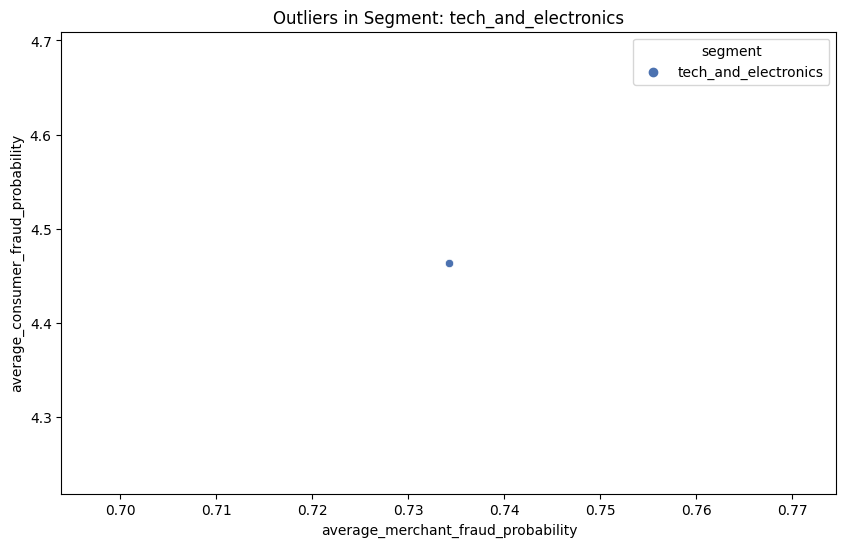

     merchant_abn                     name revenue_level  take_rate  \
803   93260930990  Pede Cras Vulputate Ltd             b       3.15   

     average_merchant_fraud_probability  number_of_consumers  \
803                            0.734226                 1913   

     average_consumer_fraud_probability  number_of_repeat_consumers  \
803                            4.463883                        84.0   

     number_of_orders  average_cost_of_order  number_of_postcodes  \
803              2001            3733.194128                 2001   

     avg_total_weekly_personal_income  avg_total_weekly_fam_income  \
803                        791.914043                  1996.282859   

     avg_median_age  avg_num_of_consumers_per_postcode merchant_description  \
803       43.050475                           1.461651              telecom   

                  segment  log_average_cost_of_order  log_number_of_orders  
803  tech_and_electronics                   8.225287              7.6

/tmp/ipykernel_1997/3220974520.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')


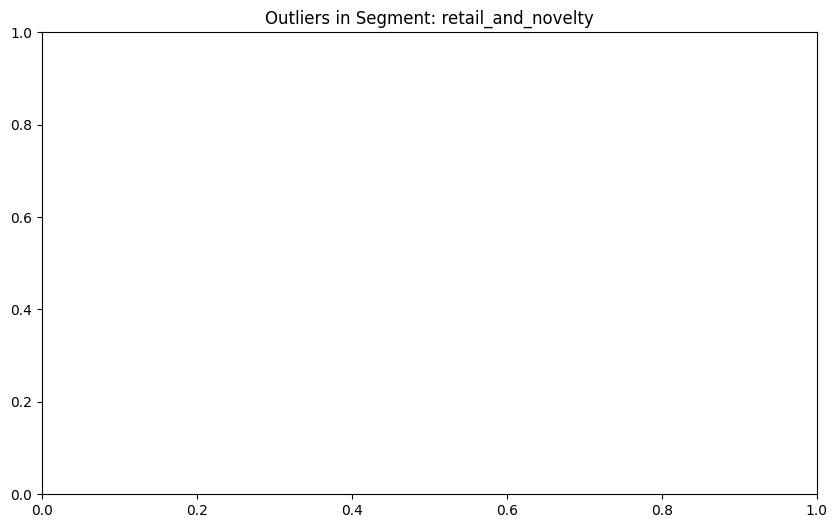

Empty DataFrame
Columns: [merchant_abn, name, revenue_level, take_rate, average_merchant_fraud_probability, number_of_consumers, average_consumer_fraud_probability, number_of_repeat_consumers, number_of_orders, average_cost_of_order, number_of_postcodes, avg_total_weekly_personal_income, avg_total_weekly_fam_income, avg_median_age, avg_num_of_consumers_per_postcode, merchant_description, segment, log_average_cost_of_order, log_number_of_orders]
Index: []


NameError: name 'pd' is not defined

In [19]:
outliers_list = []  # Initialize an empty list to store the outliers.

for segment in segments:
    # Filter data for the current segment
    segment_df = df.filter(df.segment == segment).toPandas()  # Convert to pandas for ease of plotting

    # Calculate 95% percentiles for both variables
    upper_merchant = segment_df['average_merchant_fraud_probability'].quantile(0.95)
    upper_consumer = segment_df['average_consumer_fraud_probability'].quantile(0.95)

    # Filter outliers
    outliers = segment_df[
        (segment_df['average_merchant_fraud_probability'] > upper_merchant) &
        (segment_df['average_consumer_fraud_probability'] > upper_consumer)
    ]

    # Append the outliers to the list
    outliers_list.extend(outliers.to_dict('records'))

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')
    plt.title(f'Outliers in Segment: {segment}')
    plt.show()
    print(outliers)

# After the loop, you can create a DataFrame from the outliers_list and remove those rows from the original DataFrame if needed.
outliers_df = pd.DataFrame(outliers_list)
